### __MLP-Mixer__

In [1]:
import os 
import numpy as np 
import pandas as pd 
import torch 
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

from torchvision.transforms import v2 
from tqdm import tqdm 

We will again be implementing our __MLP-Mixer__ model on __CIFAR10__ dataset. This dataset has $60,000$ images of size $32 \times 32$ in 10 classes with $6000$ image per class, so fairly balanced. This dataset, in addition, is already divided into $50,000$ training and $10,000$ test images. 

We will split $5,000$ off of training to create a validation set, leaving training set with $45,000$

In [2]:
#getting test_set first to capture mean and std
from torchvision.datasets import CIFAR10

root = "./data"
test_set = CIFAR10(root=root, train=False, download=True, transform=None)

Files already downloaded and verified


In [3]:
def compute_mean_std(dataset):
    """"
    To compute Mean and Standard Deviation for each channel
    """

    mean = torch.zeros(3)  
    std = torch.zeros(3)   
    total_pixels = 0

    for image, _ in dataset:
        image = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])(image)  # Converting images to tensors
        image = image.view(3, -1)  # Flattening the image to [3, height*width]
        mean += image.sum(dim=1)   # getting the sum of pixel values for each channel
        std += (image ** 2).sum(dim=1)  #getting the sum of squared pixel values for each channel
        total_pixels += image.size(1)

    # Computing the mean and std across the entire dataset
    mean /= total_pixels
    std = torch.sqrt(std / total_pixels - (mean ** 2))

    return mean.tolist(), std.tolist()

In [4]:
#Getting Mean and Standard Deviation from earlier defined function, 
# and apply transformation using it through Normalize and other augmentation

mean, std = compute_mean_std(test_set)

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    v2.Normalize(mean=mean, std=std)
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

Downloading training set as well, separating validation set out of training set, appling augmentations, and finally creating DATALOADER for each subsets

In [5]:
from torch.utils.data import DataLoader

train_set = CIFAR10(root=root, train=True, transform=train_transform, download=True)

#again same for validation set, this is to different augmentatio application 
validation_set = CIFAR10(root=root, train=True, transform=test_transform, download=True)
test_set = CIFAR10(root=root, train=False, transform=test_transform, download=True)

#separating out distinct train_set and validation set
train_set, _ = torch.utils.data.random_split(train_set, [45000, 5000],generator=torch.Generator().manual_seed(42))
_, validation_set = torch.utils.data.random_split(validation_set, [45000, 5000], generator=torch.Generator().manual_seed(42))


#Next, creating DataLoader(s)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True,num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=128, shuffle=True, drop_last=False ,num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## __MLP-Mixer Architecture__


Just like ViT model, __MLP-Mixer__ also takes input  as a sequence of $S$ non-overlapping image patches. If the input image has resolution $(H, W)$ and we have decided on ``patch_size`` $P$, then the number of patches would be $S = \frac{H× W}{P^2}$

Next, MLP-Mixer architecture takes these sequence of patches resulted as a table of $X∈ \mathbb{R}^{S× C}$ or __patches x channels__ and pass it into two MLP blocks i.e., __token mixing__ and __channel mixing__

- __Token-mixing MLP__ acts on column of $X$ i.e, it operates independently on each channel, applying same weight to every token of a column.

- __Channel-mixing MLP__ acts on row of $X$ it operates independently on each row of tokens, providing positional invariance 

Both MLP blocks contains two fully-connected layers with a non-linearity (GELU) in between. 



Additionally, in MLP-Mixer architecture, __skip connections__ are added in both MLPs (token-mixing or channel_mixing) to stabilize training, and __Layer Normalization__ is also applied before each MLP to normalize the inputs.

It can be written as :

$$U_{*, i} = X_{*,i} + W_2 σ (W_1 \text{LayerNorm}(X)_{*,i}) \qquad \text{for}  i = 1\cdots C$$

$$Y_{j, *} = U_{j,*} + W_4 σ (W_3 \text{LayerNorm}(U)_{j,*}) \qquad \text{for}  i = 1\cdots S$$

Lastly, a classification head with global average pooling layer is used with a linear classifier to get predictions on image labels

Source: [Tolstikhin, I.O., Houlsby, N., Kolesnikov, A., Beyer, L., Zhai, X., Unterthiner, T., Yung, J., Steiner, A., Keysers, D., Uszkoreit, J. and Lucic, M., 2021. Mlp-mixer: An all-mlp architecture for vision. Advances in neural information processing systems, 34, pp.24261-24272.](https://proceedings.neurips.cc/paper/2021/file/cba0a4ee5ccd02fda0fe3f9a3e7b89fe-Paper.pdf)

We can use ``img_to_patches`` function created for ViT here again.

In [6]:
def img_to_patch(img, patch_size, flatten_channels=True):
    """
    Args:
        img: image tensor with shape [B, C, H, w]
            where 
            B: batch size (no. of images in a batch)
            C: no. of color channels (3 in RGB)
            H: Height of image
            W: Width of image
        patch_size: no. of pixels in each dimension of patch. if 4, we have 4x4 pixels
        flatten_channel: A Boolean flag. If TRUE - flatten into feature vector, otherwise image grid
    """
    B, C, H, W = img.shape
    img = img.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    img = img.permute(0, 2, 4, 1, 3, 5) #gives (B, C, H//patch_size, W//patch_size, patch_size, patch_size)
    img = img.flatten(1,2) #[B, (H//patch_size * W//patch_size), C, patch_size, patch_size]
    if flatten_channels:
        img = img.flatten(2,4) #[B, (H//patch_size * W//patch_size), (C * patch_size * patch_size)]
    return img

In [7]:
class MlpBlock(nn.Module):
    
    def __init__(self, input_dim, mlp_dim, dropout=0.0):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, mlp_dim) #mapping input_dim to hidden_dim
        self.fc2 = nn.Linear(mlp_dim, input_dim) #mapping hidden_dim back to input_dim
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class MixerBlock(nn.Module):
    def __init__(self, num_patches, tokens_mlp_dim, channels_mlp_dim, hidden_dim, dropout):
        super().__init__()
        
        #Layer Normalization for Token-Mixing MLP and Channel-Mixing MLP
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        #Token-Mixing MLP: Operates on the token dimension (num_patches)
        self.token_mixing = MlpBlock(num_patches, tokens_mlp_dim, dropout)
        #Channel-Mixing MLP: Operates on the Channel Dimension (hidden_dim)
        #HIDDEN_DIM is actually Number of Channels
        self.channel_mixing = MlpBlock(hidden_dim, channels_mlp_dim, dropout)

    def forward(self, x):
        
        #Token-Mixing MLP
        y = self.norm1(x)           #Shape: [B, num_patches, hidden_dim] 
        y = y.transpose(1, 2)       #Shape: [B, hidden_dim, num_patches]
        y = self.token_mixing(y)    #Shape: [B, hidden_dim, num_patches]
        y = y.transpose(1, 2)       #Shape: [B, num_patches, hidden_dim]
        x = x + y                   #RESIDUAL Connection - Shape: [B, num_patches, hidden_dim]

        # Channel-Mixing MLP
        y = self.norm2(x)               # Shape: [B, num_patches, hidden_dim]
        x = x + self.channel_mixing(y)  # Shape: [B, num_patches, hidden_dim]
        return x

In [8]:
class MlpMixer(nn.Module):
    def __init__(self, patch_size, hidden_dim, tokens_mlp_dim, channels_mlp_dim, dropout):
        
        super().__init__()

        self.patch_size = patch_size
        self.hidden_dim = hidden_dim

        H, W = 32, 32 
        self.num_patches = (H // patch_size) * (W // patch_size)
        self.patch_projection = nn.Linear(3 * patch_size * patch_size, hidden_dim)

        self.mixer_block = MixerBlock(num_patches = self.num_patches,tokens_mlp_dim = tokens_mlp_dim,
                channels_mlp_dim= channels_mlp_dim, hidden_dim = hidden_dim, dropout=dropout)

        self.norm = nn.LayerNorm(hidden_dim)
        self.head = nn.Linear(hidden_dim, 10) #Number of classes is 10

    def forward(self, x):
        
        #Input shape: [B, C, H, W] = [batch_size, 3, 32, 32]
        #IMG_TO_PATCH changes it to [B, num_patches, (C * patch_size * patch_size)]
        x = img_to_patch(x, self.patch_size, flatten_channels=True) # In our case Shape [B, 64, 48] 
        x = self.patch_projection(x) # Shape: [B, num_patches, hidden_dim] In our case: [B, 64, 512]

        x = self.mixer_block(x) # Shape: [B, num_patches, hidden_dim]
        x = self.norm(x)        # Shape: [B, num_patches, hidden_dim]

        #Global average pooling and Final classification
        x = x.mean(dim=1)   #shape: [B, hidden_dim]
        x = self.head(x)    #Shape: [B, 10]
        return x

In [9]:
# Hyperparameters
patch_size = 4
hidden_dim = 512
tokens_mlp_dim = 256  # Should be >= num_tokens (64 for patch_size=4)
channels_mlp_dim = 1024
dropout = 0.2

In [10]:
model = MlpMixer(patch_size, hidden_dim, tokens_mlp_dim, channels_mlp_dim, dropout)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of Training Parameters: {count_parameters(model):,}")

Number of Training Parameters: 1,116,490


In [11]:
num_epochs = 30
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_model(model, train_loader, validation_loader, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for input_data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):

            optimizer.zero_grad()
            outputs = model(input_data)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for input_data, labels in tqdm(validation_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):

                outputs = model(input_data)
                val_loss += F.cross_entropy(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(validation_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} || "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% || "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Training
import time

start_time = time.time()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, validation_loader, optimizer, num_epochs)
training_time = time.time() - start_time

hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Total training time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

Epoch 1/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.78it/s]


Epoch 1/30 || Train Loss: 1.7399, Train Acc: 35.66% || Val Loss: 1.5129, Val Acc: 45.60%


Epoch 2/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 2/30 || Train Loss: 1.4342, Train Acc: 47.98% || Val Loss: 1.3755, Val Acc: 51.56%


Epoch 3/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.80it/s]


Epoch 3/30 || Train Loss: 1.3299, Train Acc: 52.05% || Val Loss: 1.3064, Val Acc: 53.98%


Epoch 4/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.75it/s]


Epoch 4/30 || Train Loss: 1.2748, Train Acc: 54.00% || Val Loss: 1.3131, Val Acc: 54.02%


Epoch 5/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.70it/s]


Epoch 5/30 || Train Loss: 1.2271, Train Acc: 55.78% || Val Loss: 1.2708, Val Acc: 56.34%


Epoch 6/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s]


Epoch 6/30 || Train Loss: 1.1888, Train Acc: 57.15% || Val Loss: 1.1724, Val Acc: 58.92%


Epoch 7/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.65it/s]


Epoch 7/30 || Train Loss: 1.1596, Train Acc: 58.40% || Val Loss: 1.1499, Val Acc: 59.48%


Epoch 8/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s]


Epoch 8/30 || Train Loss: 1.1335, Train Acc: 59.35% || Val Loss: 1.1800, Val Acc: 58.48%


Epoch 9/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 9/30 || Train Loss: 1.1058, Train Acc: 60.48% || Val Loss: 1.1368, Val Acc: 60.54%


Epoch 10/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s]


Epoch 10/30 || Train Loss: 1.0843, Train Acc: 61.28% || Val Loss: 1.1176, Val Acc: 60.46%


Epoch 11/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


Epoch 11/30 || Train Loss: 1.0634, Train Acc: 61.87% || Val Loss: 1.0967, Val Acc: 61.66%


Epoch 12/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


Epoch 12/30 || Train Loss: 1.0424, Train Acc: 62.82% || Val Loss: 1.0711, Val Acc: 61.90%


Epoch 13/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


Epoch 13/30 || Train Loss: 1.0187, Train Acc: 63.82% || Val Loss: 1.0798, Val Acc: 62.12%


Epoch 14/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 14/30 || Train Loss: 1.0086, Train Acc: 64.08% || Val Loss: 1.0421, Val Acc: 63.74%


Epoch 15/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


Epoch 15/30 || Train Loss: 0.9885, Train Acc: 64.86% || Val Loss: 1.0171, Val Acc: 64.42%


Epoch 16/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


Epoch 16/30 || Train Loss: 0.9749, Train Acc: 65.44% || Val Loss: 1.0027, Val Acc: 64.08%


Epoch 17/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


Epoch 17/30 || Train Loss: 0.9572, Train Acc: 66.13% || Val Loss: 1.0414, Val Acc: 64.90%


Epoch 18/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]


Epoch 18/30 || Train Loss: 0.9429, Train Acc: 66.45% || Val Loss: 1.0064, Val Acc: 65.00%


Epoch 19/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


Epoch 19/30 || Train Loss: 0.9284, Train Acc: 67.04% || Val Loss: 1.0069, Val Acc: 65.50%


Epoch 20/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


Epoch 20/30 || Train Loss: 0.9187, Train Acc: 67.39% || Val Loss: 0.9904, Val Acc: 65.22%


Epoch 21/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.71it/s]


Epoch 21/30 || Train Loss: 0.9143, Train Acc: 67.47% || Val Loss: 0.9970, Val Acc: 65.98%


Epoch 22/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


Epoch 22/30 || Train Loss: 0.8941, Train Acc: 68.14% || Val Loss: 0.9988, Val Acc: 65.28%


Epoch 23/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


Epoch 23/30 || Train Loss: 0.8886, Train Acc: 68.59% || Val Loss: 0.9714, Val Acc: 65.98%


Epoch 24/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.69it/s]


Epoch 24/30 || Train Loss: 0.8757, Train Acc: 69.05% || Val Loss: 0.9476, Val Acc: 67.02%


Epoch 25/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


Epoch 25/30 || Train Loss: 0.8745, Train Acc: 69.11% || Val Loss: 0.9695, Val Acc: 66.80%


Epoch 26/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


Epoch 26/30 || Train Loss: 0.8616, Train Acc: 69.44% || Val Loss: 0.9646, Val Acc: 66.48%


Epoch 27/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]


Epoch 27/30 || Train Loss: 0.8512, Train Acc: 69.88% || Val Loss: 1.0176, Val Acc: 64.92%


Epoch 28/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


Epoch 28/30 || Train Loss: 0.8385, Train Acc: 70.53% || Val Loss: 0.9071, Val Acc: 68.10%


Epoch 29/30 - Validation: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


Epoch 29/30 || Train Loss: 0.8381, Train Acc: 70.34% || Val Loss: 0.9506, Val Acc: 67.42%


Epoch 30/30 - Validation: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s]

Epoch 30/30 || Train Loss: 0.8304, Train Acc: 70.80% || Val Loss: 0.9016, Val Acc: 68.64%
Total training time: 1h 48m 48.60s


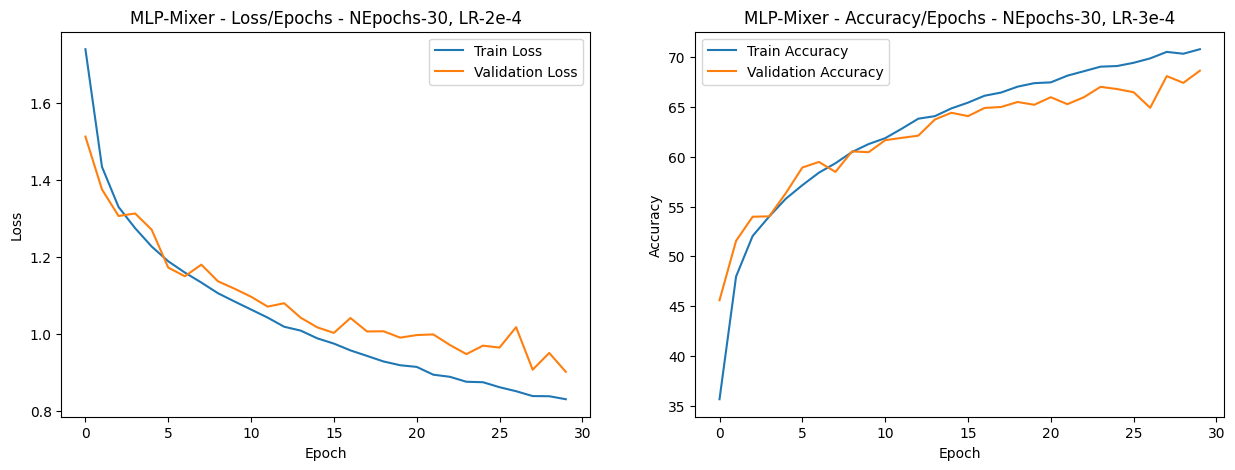

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP-Mixer - Loss/Epochs - NEpochs-30, LR-2e-4')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MLP-Mixer - Accuracy/Epochs - NEpochs-30, LR-3e-4')
plt.legend()

plt.savefig('MLP-Mixer_Loss_Acc_lr2e-4.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
def test_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    predictions, all_labels = [], []
    

    with torch.no_grad():
        for input_data, labels in tqdm(test_loader):
            outputs = model(input_data)

            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return predictions, all_labels, test_loss, test_accuracy

start_time = time.time()
predictions, all_labels, test_loss, test_accuracy = test_model(model, test_loader)
testing_time = time.time() - start_time
print(f"Total testing time: {testing_time:.2f} seconds")


100%|██████████| 79/79 [00:20<00:00,  3.89it/s]

Test Loss: 0.9004, Test Accuracy: 68.32%
Total testing time: 20.31 seconds


Model Accuracy: 68.32%
              precision    recall  f1-score   support

    airplane       0.65      0.78      0.71      1000
  automobile       0.69      0.86      0.76      1000
        bird       0.63      0.51      0.57      1000
         cat       0.55      0.45      0.50      1000
        deer       0.65      0.62      0.64      1000
         dog       0.68      0.54      0.60      1000
        frog       0.64      0.87      0.74      1000
       horse       0.71      0.77      0.74      1000
        ship       0.86      0.74      0.80      1000
       truck       0.80      0.69      0.74      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



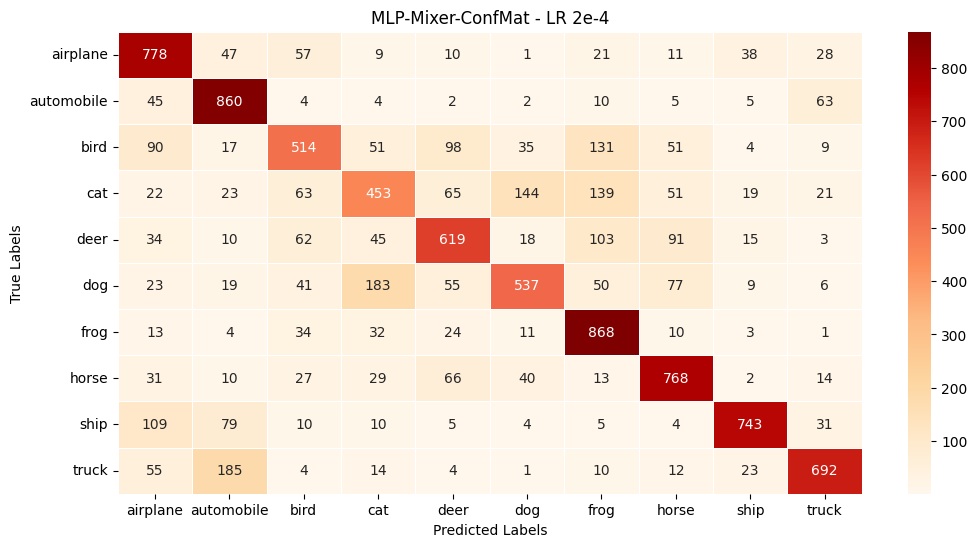

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

print(f"Model Accuracy: {accuracy_score(all_labels, predictions) * 100:.2f}%")
print(classification_report(all_labels, predictions, target_names=test_set.classes))

cm = confusion_matrix(all_labels, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd',linewidths=.5,
            xticklabels=test_set.classes, yticklabels=test_set.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MLP-Mixer-ConfMat - LR 2e-4')
plt.savefig("MLP-Mixer_ConfMat_lr2e-4.png",dpi=300,bbox_inches="tight")
plt.show()

As it appears, increasing ``num_blocks`` for MLP-Mixer block is not a good idea; better would be to increase ``hidden_dim``, ``tokens_mlp_dim``  and ``channels_mlp_dim``

For ``num_epochs = 10`` and ``learning_rate = 2e-4``, we are conducting experiment

| Ex | Mixer blocks | hidden dim | token_mlp_dim | channels_mlp_dim | Parameters | Training Time | Training Accuracy | Validation Accuracy | Model (test) Accuracy|
|------|------|------|------|------|------|------|------|------|-----|
|1| 8 | 128 | 64| 512 |   1,132,170  | 0:41 Hr| 68.9 |  69.66 |69.09 |
|2| 8 | 256 | 128 | 1024 | 4,360,970 | 2:14 Hr| 74.95 | 74.30 | 74.36|
|3| 2 | 256 | 128 | 1024 | 1,101,962 | 0:33 Hr| 68.11 | 67.72 | 66.76|
|4| 1 | 256 | 128 | 1024 | 558,794  |  0:17 Hr| 58.71 | 58.52 | 58.03|
|5| 1 | 512 | 256 | 2048 | 2,166,090 | 0:54 Hr| 61.75 | 61.20 | 61.24|
|6| 1 | 512 | 256 | 1024 | 1,116,490 | 0:35 Hr| 62.43 | 60.96 |60.28 |
|7| 1 | 256 | 256 | 1024 |   575,306 | 0:20 Hr| 59.07 | 58.18 | 57.89|
|8| 1 | 512 | 512 | 1024 | 1,149,514 | 0:46 Hr| 62.26 | 60.80 | 60.90|
|9| 1 | 512 | 128 | 1024 | 1,099,978 | 0:30 Hr| 60.14 | 57.70 | 57.26|

We have decided to proceed with 1 Mixer Block (and changed code accordingly), and then using following parameters:

- hidden_dim = 512
- tokens_mlp_dim = 256
- channels_mlp_dim  = 1024 

and then run for $30$ epochs with learning_rate as $2e-4$. Our results

| Ex  | Training Parameters | Training Time | Learning Rate | No. Epochs | Training Accuracy | Training Loss | Validation Accuracy | Validation Loss | MODEL ACCURACY|
|-------|------|--------|--------|----------|---------|--------|-------|-------|---------|
|1 |  1, 116, 490 | 1:48 Hr | 2e-4 | 30 | 70.80  |  | 68.64 |0.90 | 68.32|